![Py4Eng](img/logo.png)

# Logistic Model
## Yoav Ram

In this session we will understand:
- how logistic models can be used to classify or predict categories
- how to fit logistic models to data using maximum likelihood and gradient descent, including deriving gradients using the chain rule
- how to visualize pair plots, logistic models, histograms, and ROC curves
- the very basics of sklearn and statsmodels

In [1]:
import zipfile
import urllib.request
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logit, expit
import pandas as pd
import seaborn as sns
blue, green, red = sns.color_palette('muted', 3)
sns.set_style('ticks')
sns.set_context('talk')

In the previous section we used one feature with integer values to predict another integer value.
What if we want to predict a category or class (i.e. classify or categorize) instead of predicting a number?

There are many ways to classify data (even without a training set), and one of the most common is **logistic regression**. 
But *regression* is usually used for predicting real numbers, how is regression related to classification?
In logistic regression we are trying to regress (predict a real number) the probability of some data being in a one class and not the other. 
Logistic regression is binomial (two classes, one free variable) but it can easily be expanded to *multinomial logistic regression*, sometimes also known as *softmax regression*.

# Get me the data

Let's start with a concrete example.
We'll get some data related to the Titanic (courtesy of the [IPython Cookbook](http://ipython-books.github.io/) by Cyrille Rossant, originally from the [kaggle Titanic challenge](https://www.kaggle.com/c/titanic).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Cd51-1000g.gif/640px-Cd51-1000g.gif)

In [2]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/titanic.zip'
filename = '../data/titanic.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

titanic_zip = zipfile.ZipFile(filename)
with titanic_zip.open('data/titanic_train.csv') as f:
    df = pd.read_csv(f)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


OK, let's just work with three features (not just one) - `Sex`, `Age` and `Pclass`.
We will treat `Sex` as a category (0 or 1), `Age` as a number (positive intger), `Pclass` as another number, because it is the ticket class.

We will try to predict the `Survived` variable, which is simply 0 or 1.

In [3]:
df = df[['Sex', 'Age', 'Pclass', 'Survived']].copy() # what if I don't put .copy?
df['Sex'] = df['Sex'] == 'female' # convert to boolean
df['Sex'] = df['Sex'].astype(int) # then convert to int
df = df.dropna() # remove rows with "not a number" elements
df.head()

,Sex,Age,Pclass,Survived
0,0,22.0,3,0
1,1,38.0,1,1
2,1,26.0,3,1
3,1,35.0,1,1
4,0,35.0,3,0


# Data exploration

Let's look at the distribution of ages between survivers and fatalities using [matplotlib](http://matplotlib.org)'s `hist`.

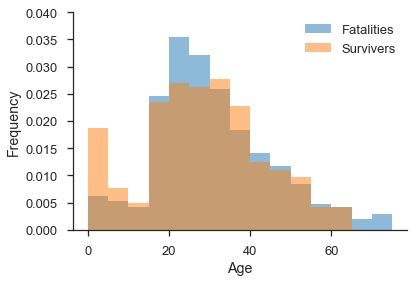

In [4]:
kws = dict(normed=True, alpha=0.5, bins=np.arange(0, df['Age'].max(), 5)) # declare keyword arguments once as a dict

plt.hist(df.loc[df['Survived']==0, 'Age'], label='Fatalities', **kws) # ** unpacks the kws dict 
plt.hist(df.loc[df['Survived']==1, 'Age'], label='Survivers', **kws)
plt.legend() # labels set in the hist call
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.ylim(0, 0.04)
sns.despine()

There seems to be a difference at ages <10 and 20-30.
What if we separate by men and women?

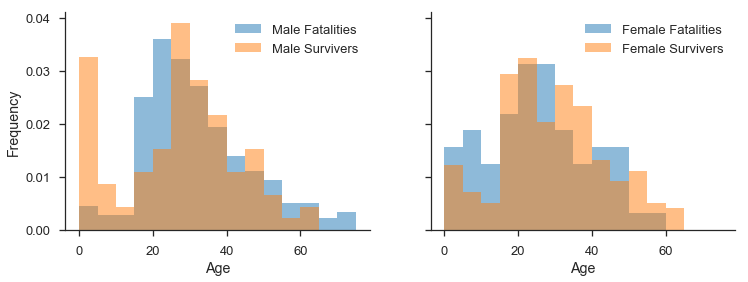

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
ax.hist(df.loc[(df['Survived']==0) & (df['Sex']==0), 'Age'], label='Male Fatalities', **kws)
ax.hist(df.loc[(df['Survived']==1) & (df['Sex']==0), 'Age'], label='Male Survivers', **kws)
ax.legend()
ax.set_ylabel("Frequency")
ax.set_xlabel("Age")

ax=axes[1]
ax.hist(df.loc[(df['Survived']==0) & (df['Sex']==1), 'Age'], label='Female Fatalities', **kws)
ax.hist(df.loc[(df['Survived']==1) & (df['Sex']==1), 'Age'], label='Female Survivers', **kws)
ax.legend()
ax.set_xlabel("Age")

sns.despine()

It does seem like young men (15-25) were more likely to die and young boys (<15) were more likely to survive.
For women, it seems that young women (<15) were likely to die and then it's not very clear.

# Logistic regression

Let's try and use logistic regression to clear this up (if we can).
How does it work?

We briefly mentioned that when predicting integer values the normal distribution, and hence the *normal linear model*, is not be the best model, and demonstrated that a [GLM](https://en.wikipedia.org/wiki/Generalized_linear_model) with a Poisson distribution and an log link function intead of a normal distribution performed better.
We will do a similar trick here.

We first use a linear model (as we did before) to predict the **log-odds** for survival.

Odds here is actually short for odds-ratio (OR), which is just the ratio of the probability that something happens and the probability that it does not happen:
$$
OR = 
\frac{P(\text{Survived})}{P(\text{Died})}
$$
so when the odds-ratio is 1, both events are as likley, and when it is >1 (<1) survival (death) is more likely.

We use the odds-ratio instead of the probability itself, because it is a value between $-\infty$ and $\infty$, rather then between 0 and 1, which is important both for mathematical formality, as the linear model is unbounded, and for interpretation - the odds can be doubles again and again (2:1 becoming 4:1 becomnig 8:1...) whereas the probability cannot (what is the double of 75%?).

The log-odds, which we mark as $z$, is the natural logarithm of the odds ratio.
$$
z = 
\log{\frac{P(\text{Survived})}{P(\text{Died})}}
$$
Why use the log-odds? Because (i) it is more mathematically convinient, as log-odds is symmetric in the probability, whereas odds is not, and (ii) it is easier to interpret, as we will see below.

So to use a linear model for predicting the log-odds, we have $m$ features, $x_1, x_2, \ldots, x_m$, and we try to estimate coefficients $a_0, a_1, \ldots, a_m$ such that
$$
z = a_0 + a_1 x_1 + \ldots + a_m x_m
$$
gives us a good prediction of the true log-odds.

From the log-odds we can find the probability for the event to occur using the *logisitic* (hence the name of the method!) or the *expit* function (same function, different name):
$$
P(\text{Survived}) = expit(z) = \frac{1}{1+e^{-z}}
$$

In [6]:
def logodds(df, coefs):
    sex, age, pclass = coefs
    z = sex * df['Sex'] + age * df['Age'] + pclass * df['Pclass']
    return z.values

In [7]:
coefs = np.array([1,1,1])
logodds(df, coefs)[:5]

array([ 25.,  40.,  30.,  37.,  38.])

# Maximum likelihood

Now we want to find suitable $a_i$ such that we make a good prediction. 
We'll use *maximum likelihood* again.

Given data $(x, y)$ where $X=(x_1, \ldots, x_m)$ are some numbers and $y$ is either 0 or 1, the logistic model provides us an estimate $\widehat y$

$$
\widehat{y} = P(y=1)=\frac{1}{1+e^{-z}} = \frac{1}{1+e^{-a_1 x_1 - \ldots -a_m x_m}}
$$

The likelihood of this model is

$$
\mathbf{L}(a_1, \ldots, a_m \mid x_1, \ldots, x_m, y) = 
P(y \mid a_1, \ldots, a_m, x_1, \ldots, x_m) = 
\cases{
    \widehat{y}, & y=1 \\
    1-\widehat{y}, & y=0
}
$$

If we have many $(x,y)$ pairs, and we will **assume that each pair is independent** (which maybe we can't always do, and specifically in the Titanic case we probably shouldn't do, but ok) then the joint likelihood of all the pairs is just the product of all the pair likelihoods: the product is used because the joint probability of independent events occuring is the product of their occurence probabilities.
Writing the set of $x$s as $X$ and the corresponding set of $y$s as $Y$, and because $y$ are either 0 or 1,

$$
\mathbf{L}(a_1, \ldots, a_m \mid X, Y) = 
\prod_{i} {(\widehat{y}_i)^{y_i} \; (1-\widehat{y}_i) ^{1-y_i}}
$$

We'll use the log-likelihood because otherwise we will have to deal with a product of really small numbers; so we take the sum of the log of the likelihood $\mathbf{L}$ of the the $(x, y)$ pairs (sum because the log of products is the sum of logs). The use of log here is not "magic", it's a mathematical convenience. It just happens that "log-likelihood" sounds very impressive.

$$
\log{\mathbf{L}(a_1, \ldots, a_m \mid X, Y)} = 
\sum_{i} {y_i \log{\widehat{y}_i} + (1-y_i) \log{(1-\widehat{y}_i)}}
$$

This is very similar to the negative of an information theory function called [*cross entropy*](https://en.wikipedia.org/wiki/Cross_entropy), and we usually average it over all the samples so that we can compare cross entropies between datasets of different size:

$$
\mathbf{J}(a_1, \ldots, a_m, X, Y) = -\frac{1}{n} \log{\mathbf{L}(a_1, \ldots, a_m \mid X, Y)}
$$

where $n$ is the number of samples in $X,Y$.

### Numerical stability

Due to numerical issues when using very small or very large numbers, we should play around with the definition a little bit to find an expression that we can calculate with good numerical stability.

Note that
$$
\log{\widehat{y}} = -\log{\Big(1 + e^{-z}\Big)}  = -\log{\Big(1 + e^{-z}\Big)} \\
\log{(1-\widehat{y})} = -z - \log{\Big(1 + e^{-z}\Big)}
$$
and therefore
$$
y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})} = \\
-y \log{\Big(1 + e^{-z}\Big)} + (1-y)\Big(-z - \log{\Big(1 + e^{-z}\Big)}\Big) = \\
(1-y)z - \log{\Big(1 + e^{-z}\Big)}
$$

Finally,
$$
\log{\mathbf{L}(a \mid X, Y)} = 
\sum_{(x,y) \in (X,Y)} {-z (1-y) - \log{\Big(1 + e^{-z}\Big)}},
$$
where $z=\text{log-odds} = a_1 x_1 + \ldots + a_n x_n$.

# Exercise: cross-entropy

Implement the cross entropy function

In [8]:
def cross_entropy(df, coefs):
    pass

In [10]:
%run -i ../solutions/logistic_model.py
cross_entropy(df, coefs)

19.753700563567072

The solution file has two implementations: `_cross_entropy` in pure-python with generator expression and `cross_entropy` using NumPy arrays.

Guess which one is faster and compare to your implementation if you want.

In [172]:
%run -i ../solutions/logistic_model.py
assert np.isclose(_cross_entropy(df, coefs), cross_entropy(df, coefs))
%timeit _cross_entropy(df, coefs)
%timeit cross_entropy(df, coefs)

3.16 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
836 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Gradient descent and the chain rule

Now we can minimize the cross entropy using gradient descent.
We need to calculate the derivative of the cross entropy with regards to $a_i$.
We will use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$
f(g(x))' = f'(g(x)) \cdot g'(x), 
$$

which is easier to write as 

$$
\frac{dx}{dy} = \frac{dx}{dz} \cdot \frac{dz}{dy}
$$

because then we can eliminate fractions as if these were fractions and not [infinitesimals](https://en.wikipedia.org/wiki/Infinitesimal).

Remember that $z=\text{log-odds} = a_0 + a_1 x_1 + \ldots + a_m x_m$ and $\mathbf{J}$ is the cross entropy function which we want to minimize.

Then 
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k}
$$

The easiest one is:

$$
\frac{\partial z}{\partial a_k} = x_k
$$

The derivative of the logistic function is (you can verify later):

$$
\frac{\partial \widehat y}{\partial z} = \widehat y ( 1-\widehat y )
$$

Next, because $\frac{d}{dx} log(x) = \frac{1}{x}$ (again, you can verify this),

$$
\frac{\partial \mathbf{J}}{\partial \widehat y} = 
- \frac{\partial}{\partial \widehat y} \big(y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})}\big) = \\
-y \cdot \frac{1}{\widehat y} + (1-y) \cdot \frac{1}{1-\widehat y} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)}
$$

Putting it all together,
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)} \cdot \widehat y ( 1-\widehat y ) \cdot x_k = \\
(\widehat y - y) \cdot x_k
$$

which you have to admit is pretty cool: this is the residual (i.e. difference between the predicted and oberverd probabilities, $\widehat y - y$), so 0 when you got it right and 1 or -1 when you got it completely wrong, multiplied by the stength of the signal, so that strong signals (large $x_k$) have a stonger gradient and stonger effect on the result.

This was the gradient for a single sample. We average it over all samples to get a good estimate of the "real gradient" (law of large numbers etc.).

# Exercise: gradient descent

Implement a `gradient_descent(df, coefs, eta)` function, similar to the one we had in the [linear model session](linear-model.ipynb), which returns updated values for the coefficients based on one iteration of the gradient descent algorithm.
Use the above derivation to calculate the gradients and return updated coefficients.

In [11]:
def gradient_descent(df, coefs, eta=0.01):
    pass

When your solution is ready, comment out the first line of the next cell and run it.

In [14]:
%run -i ../solutions/logistic_model.py
gradient_descent(df, coefs)

array([ 0.99910465,  0.81814023,  0.98525564])

# Fitting the logistic model

Fitting the model is done in much the same way as we did with the linear model - just have to choose initial coefficeints, different stopping condition, and adjust to the API of the new `gradient_descent` function.

This time we stop when the difference in cross entropy between two iterations is smaller than some value ($10^{-4}$).

In [18]:
def logistic_model(df, coefs=(1, 1, 1), rel_err=1e-4):
    coefs = np.array(coefs)
    J, J_ = 0, 1
    t = 0
    while abs(J - J_) > rel_err:
        t += 1
        coefs = gradient_descent(df, coefs)
        if t % 1000 == 0:
            J_, J = J, cross_entropy(df, coefs)
            print("{}: loss={:.6f}, a={}".format(t, J, coefs))        
    return coefs

In [19]:
coefs = logistic_model(df)

1000: loss=0.588977, a=[ 1.62297763 -0.03317644 -0.47324615]
2000: loss=0.484932, a=[ 2.02107761 -0.00511541 -0.54625834]
3000: loss=0.479989, a=[ 2.22690541 -0.00313758 -0.57976562]
4000: loss=0.478105, a=[ 2.36128092 -0.00329133 -0.60276203]
5000: loss=0.477268, a=[ 2.45077441 -0.00336833 -0.61850152]
6000: loss=0.476887, a=[ 2.51115811 -0.00340854 -0.62931515]
7000: loss=0.476711, a=[ 2.55225955 -0.00343039 -0.63676596]
8000: loss=0.476628, a=[ 2.58040324 -0.00344276 -0.64191031]


In [20]:
print("Odds-ratios:")
print("sex 		age 	     pclass")
print(np.exp(coefs))

Odds-ratios:
sex 		age 	     pclass
[ 13.20246083   0.99656316   0.52628609]


We can interpret these results as follows:
- women were much more likely to survive
- older passengers were less likely to survive
- passengers with expensive tickets were much move likely to survive

Of course, some of these features are likely interacting: for example, age and class seem to be correlated:

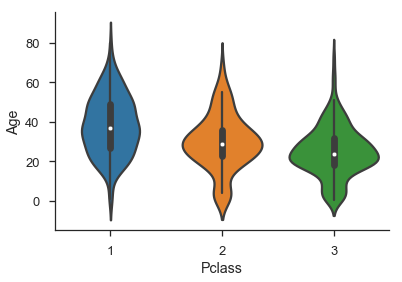

In [21]:
sns.violinplot(x='Pclass', y='Age', data=df)
sns.despine()

# Model performence

There are different ways to assess the performence of a classification model and it really depends on what exactly we want to do with it.
But a good score for now is the *accuracy*, which tells us the fraction of cases in which our model agrees with the truth.
Of course, our model outputs *probabilities*, and we need to convert these to classes. 
We will just decide that if the predicted survival probability is 0.5 then that person survived.

In [26]:
probs = expit(logodds(df, coefs))
predictions = probs > 0.5
truth = df['Survived'].values

print("Accuracy: {}".format((predictions == truth).mean()))

Accuracy: 0.7801120448179272


Again, this can be done in different ways.

The threshold we pick (i.e. 0.5) can balance between the probability to give an incorrect positive answer and the probability to give a correct positive answer.
These are called the false-positive rate and true-positive rates.

Think for example on what we would like to do if we are trying to predict if a person is has a disease. 
You might consider that it is preferable to sometimes tell someone they are ill when they are actually not, and then running more tests, rather than sometimes telling people they are healthy when they are actually ill, and having them cause damage to themselves or others.

Let's suppose that a positive answer is "person survived the Titanic" that is $y=1$ or `truth==1` and use *scikit-learn*'s utility to calculate and plot the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

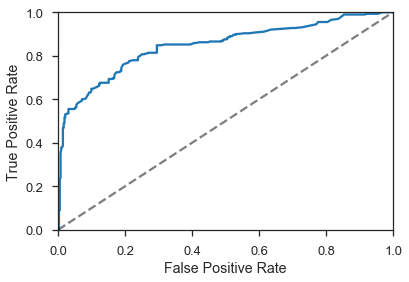

In [27]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(truth, probs)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'--k', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

An "ideal" model will shoot directly to the top, that is, have maximum TPR for any FPR.
A "random" or "naive" model can be expected to follow the dashed line.

# Off-the-shelf solutions

Of course, we should use solutions that someone else already optimized and debugged.

## Scikit-learn

[scikit-learn](http://scikit-learn.org/stable/index.html) is an awesone machine learning package will very good documentation.
Note that the package name is `sklearn`.

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
model = LogisticRegression(fit_intercept=False)
model.fit(df[['Sex', 'Age', 'Pclass']], df['Survived'])
model.score(df[['Sex', 'Age', 'Pclass']], df['Survived'])

0.78011204481792717

## statsmodels

[statsmodels](http://statsmodels.sourceforge.net/) is also a good package, more oriented to statistics then machine learning.

In [25]:
import statsmodels.api as sm

In [27]:
X = df[['Sex', 'Age', 'Pclass']]
logit = sm.Logit(df['Survived'], X)
result = logit.fit()
predictions = result.predict(X) > 0.5
truth = df['Survived'].values
print("Accuracy: {}".format((predictions == truth).mean()))

Optimization terminated successfully.
         Current function value: 0.476553
         Iterations 6
Accuracy: 0.7801120448179272


In [28]:
summary = pd.concat([
    np.exp(result.params),
    np.exp(result.conf_int()),
    result.pvalues
], axis=1)
summary.columns = ['Odds ratio', '95% CI Low', '95% CI High', 'P-value']
summary

,Odds ratio,95% CI Low,95% CI High,P-value
Sex,14.056245,9.633298,20.509905,8.809118e-43
Age,0.996543,0.987879,1.005283,4.370385e-01
Pclass,0.520227,0.451981,0.598779,8.395339e-20


# Serialization

Many Python objects can be serialized using the [`pickle`](https://docs.python.org/3.6/library/pickle.html) module, and those that can't can sometimes be serilized with the help of [`dil`](https://github.com/uqfoundation/dill) or [`cloudpickle`](https://github.com/cloudpipe/cloudpickle).

The `pickle` API is very simple -- `dump` to file-like object, `dumps` to string, `load` from file-like object, `loads` from string. Other serialization modules (e.g. [`json`](https://docs.python.org/3.6/library/json.html)) also use the same API, but must be extended to serialize arbitrary classes.

If you also need to sign the serialized object so that it can be trusted, check out [`itsdangerous`](http://pythonhosted.org/itsdangerous/).

# Exercise

See the [tennis exercise](../exercises/logistic_tennis.ipynb), in which you will try to predict who won a tennis game - player 1 or player 2.

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.2**.
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (a similar Titanic example is shown in chapter "Predicting who will survive on the Titanic with logistic regression"). 
- Scikit-learn documentation has a [tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#classification) using the classical Iris dataset, with examples for other classification methods other than logistic regression.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)